In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

In [3]:
import os
import sys

src_dir = './../../src/'
sys.path[0] = src_dir

import matplotlib.pyplot as plt

import glob

import numpy as np
import pandas as pd
import seaborn as sns

from collections import OrderedDict

from access_biology_data import meta, relations, properties
from access_literature_data import medline
from access_science_shared import standardizer 

In [4]:
sys.path.append('./../src/')
from aging_tools import inout, export
from access_aging_data import earlier_studies, chaperome, companions, sequencing

from access_science_shared import standardizer

In [5]:
from narrative import nar181026_heat_confidence_genes
from narrative import nar181205_networks

In [6]:
from access_science_shared import mapper

In [7]:
from aging_tools import inout, export, calculators

In [8]:
save_images = True

In [9]:
outfolder = '200507_schaum'

In [10]:
taxon_id = 10090

In [11]:
ref_genes = standardizer.reference_genes(taxon_id, 'orp')

/Users/tstoeger/anaconda3/lib/python3.7/site-packages/fastparquet/dataframe.py:5: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import CategoricalIndex, RangeIndex, Index, MultiIndex


In [12]:
pr = properties.genbank_validated_rna(taxon_id)[['gene_ncbi', 'Genbank_validated_RNA: full_SumACGT']].rename(columns={
    'Genbank_validated_RNA: full_SumACGT': 'length'
})

pr.loc[:, 'log_length'] = np.log10(pr['length'])

In [13]:
pr = pr[pr['gene_ncbi'].isin(ref_genes)]

In [14]:
from scipy.stats import spearmanr

In [15]:
p_base = inout.get_internal_path('dynamic/tstoeger/200501_schaum')

In [16]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(p_base) if isfile(join(p_base, f))]

In [17]:
drawer = pd.Series(onlyfiles).to_frame('filename')

In [18]:
drawer['tissue'] = drawer['filename'].str.extract('(.*)_[0-9]+_vs')

In [19]:
drawer['first'] = drawer['filename'].str.extract('.*_([0-9]+)_vs').astype(float)

In [20]:
drawer['last'] = drawer['filename'].str.extract('.*_[0-9]+_vs_([0-9]+)').astype(float)

In [21]:
drawer['tissue'] = drawer['tissue'].str.replace('_', ' ')

In [22]:
sorted(drawer['last'].unique())

[1.0, 3.0, 6.0, 9.0, 12.0, 15.0, 18.0, 21.0, 24.0, 27.0]

In [23]:
young_age = 3

In [24]:
ages = [int(x) for x in sorted(drawer[drawer['last']>young_age]['last'].unique())]

In [25]:
tissues = drawer['tissue'].unique()

In [26]:
organizer = drawer[
    (drawer['first'].isin(ages)) & 
    (drawer['last']==young_age) 
].rename(columns={'first': 'older', 'last': 'younger'}).reset_index(drop=True)

In [27]:
out_rho = pd.DataFrame(index=tissues, columns=ages)
out_pvalue = pd.DataFrame(index=tissues, columns=ages)

In [28]:
for j in organizer.index:
    filename = organizer.loc[j, 'filename']
    tissue =  organizer.loc[j, 'tissue']
    older =  organizer.loc[j, 'older']

    p = os.path.join(p_base, filename)

    df = pd.read_csv(
        p, usecols=['gene_ID', 'log2FoldChange', 'pvalue', 'padj']
    ).sort_values('gene_ID').rename(columns={'gene_ID': 'gene_ensembl'}).dropna(
    subset=['log2FoldChange'])
    
    df = mapper.gene_ensembl_2_gene_ncbi_unambiguously(df, 10090).reset_index()
    
    df = pd.merge(df, pr)
    rho, pval = spearmanr(df['log_length'], df['log2FoldChange'])
    
    
    out_rho.loc[tissue, older] = rho
    out_pvalue.loc[tissue, older] = pval

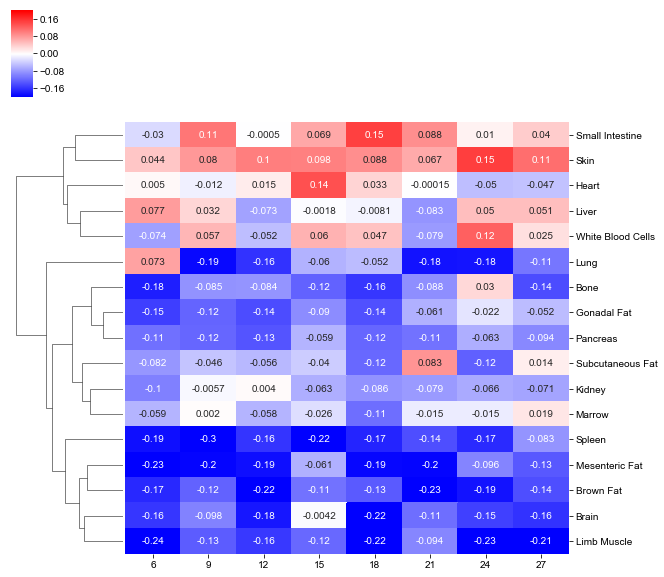

In [29]:
ix = sns.clustermap(
    out_rho.astype(float), 
    col_cluster=False, 
    cmap='bwr', 
    vmin=-0.2, 
    vmax=0.2,
    annot=True
)

if save_images:
    export.export_image(
        os.path.join(outfolder, 'imbalance.pdf')
    )

In [30]:
order = out_rho.index[ix.dendrogram_row.reordered_ind]

In [31]:
pv = out_pvalue.astype(float).apply(lambda x: -np.log10(x)).reindex(order)

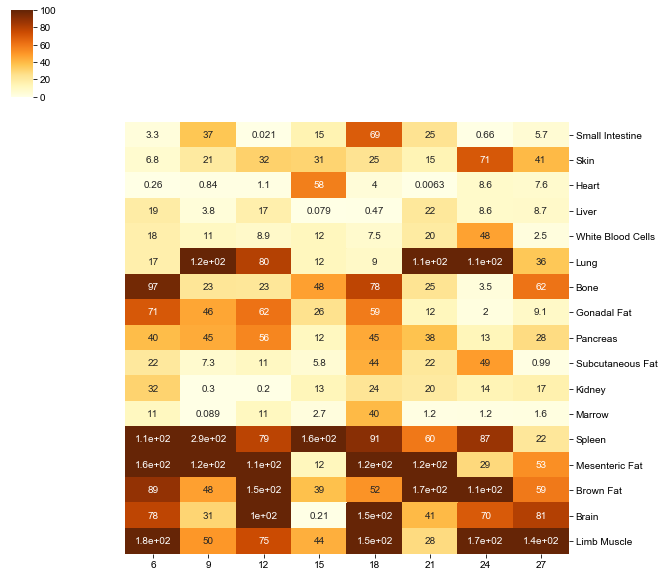

In [32]:
sns.clustermap(
    pv, 
    annot=True, 
    cmap='YlOrBr',
    vmin=0,
    vmax=100,
    row_cluster=False, 
    col_cluster=False)

if save_images:
    export.export_image(
        os.path.join(outfolder, 'imbalance_pvalue.pdf')
    )

In [33]:
stacked = out_rho.stack().to_frame('rho').astype(float).rename_axis(['tissue', 'age']).reset_index()

In [34]:
extr = stacked['rho'].abs().max()+0.05

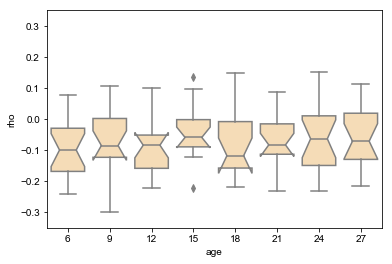

In [35]:
sns.boxplot(x='age', y='rho', data=stacked, notch=True, color='navajowhite', order=ages)
plt.ylim([-extr, extr])

if save_images:
    export.export_image(
        os.path.join(outfolder, 'imbalance_boxplot.pdf')
    )